# Gaussian Processes

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from functools import partial

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## Visualizing 2D Gaussians

Gaussian processes use multivariate normal distributions (Gaussians). The code below visualizes 2-dimensional Gaussians and their dependence on the mean $\mu$ and the covariance matrix $\Sigma$.

Change the values of `mu` ($\mu$) and `Sigma` ($\Sigma$) to see its effect on the distribution.

In [15]:
def visualise_2d_gaussian(mu, Sigma, x_min=-3, x_max=3, y_min=-3, y_max=3, n_points=40):
        
    X = np.linspace(x_min, x_max, n_points)
    Y = np.linspace(y_min, y_max, n_points)
    X, Y = np.meshgrid(X, Y)
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty((n_points, n_points, 2))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    Z = multivariate_normal.pdf(pos, mu, Sigma)

    fig = plt.figure(figsize=(8, 4))

    ax1 = fig.add_subplot(1, 2,1,projection='3d')

    ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1,cmap=cm.viridis)
    ax1.view_init(55,-70)
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.set_xlabel(r'$x_1$')

    # 2D plot
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.contourf(X, Y, Z, cmap=cm.viridis)
    #ax2.set_xticks([])
    #ax2.set_yticks([])
    ax2.set_xlabel(r'$x_1$')
    ax2.set_ylabel(r'$x_2$')

    plt.show()

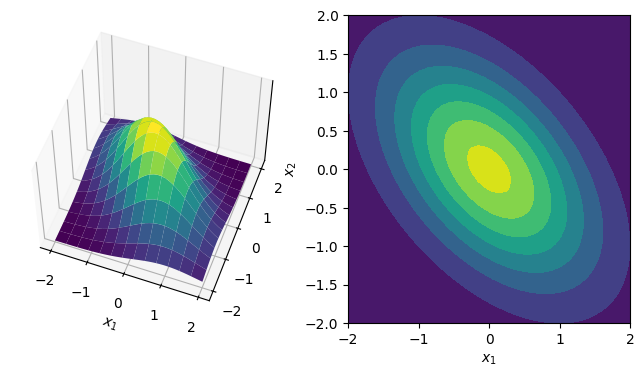

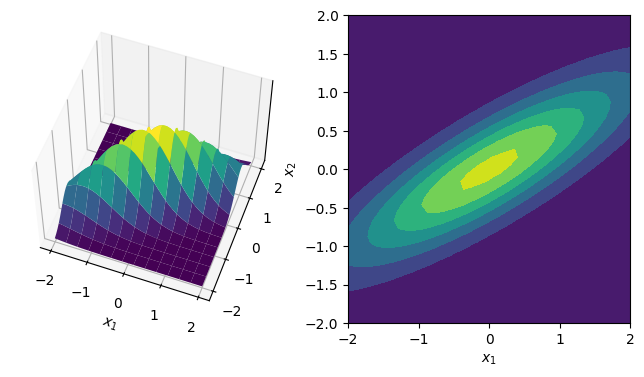

In [16]:
n_points = 40
x_min = y_min = -2
x_max = y_max = 2

# Mean vector and covariance matrix
posterior_mu = np.array([0., 0.])
Sigma = np.array([
    [ 1. , -0.5], 
    [-0.5,  1.]
])
Sigma2 = np.array([
    [ 2, 1.0], 
    [1.0,  0.7]
])

visualise_2d_gaussian(posterior_mu, Sigma, x_min, x_max, y_min, y_max, n_points)
visualise_2d_gaussian(posterior_mu, Sigma2, x_min, x_max, y_min, y_max, n_points)

# Modelling prior distribution

The prior distribution of a GP is a multivariate Gaussian distribution with mean $\mu$ (often $\mu=0$) and a covariance matrix $\Sigma$. 
$$
Y \sim N(0, \Sigma)
$$

The dimension of the prior distribution is equal to the number of test points $N$ (test points $x_1, x_2, ..., x_N$). The points can be any elements, even multidimensional.

The covariance matrix ($N \times N$) is produced by a given kernel function which computes the similarity between every pair of inputs.

Each sample from the prior distribution represents possible output values ($f*$), based only on the test input values ($x*$).

## Kernels

Kernels are used by GPs as a similarity measure between input vectors. The most commonly used kernel is Radial basis function kernel. Any object can be used as an input vector as long as a kernel is defined. 
### Radial basis function kernel (squared-exponential kernel)

$$
k(x, x')=\sigma^2exp{\frac{-d(x, x')^2}{2l^2}}
$$
With following parameters:
- $\sigma$ variance
- $l$ length scale
- $d(x, x')$ Euclidean distance between vectors $x$ and $x'$.


In [17]:
def rbf_kernel(x, x_prime, length, sigma):
    # Implementation of Radial basis function kernel
    dist = np.linalg.norm(x - x_prime, ord=2, axis=-1)
    #dist = np.abs(x - x_prime)

    return (sigma**2) * np.exp(-dist/(2 * length**2))

def white_noise_kernel(x, x_prime, noise_level):
    cov_matrix = np.abs(np.random.normal(0, noise_level, size=x.shape[:-1]))
    
    if len(cov_matrix.shape) > 1:
        return cov_matrix * np.eye(cov_matrix.shape[0], cov_matrix.shape[1])
    return cov_matrix


def exp_sine_squared_kernel(x, x_prime, sigma, length, periodicity):
    if periodicity <= 0:
        raise ValueError("Periodicity of Exp-Sine-Squared kernel must be strictly positive.")
    if length <= 0:
        raise ValueError("Length of Exp-Sine-Squared kernel must be strictly positive.")
    
    dist = np.linalg.norm(x - x_prime, ord=2, axis=-1)
    #dist = np.abs(x - x_prime)
    return (sigma ** 2) *  np.exp((-2 * (np.sin(np.pi*dist / periodicity) ** 2)) / length ** 2)


def linear_kernel(x, x_prime, offset, sigma_b, sigma):
    x_offset = x - offset
    x_prime_offset = x_prime - offset
    if len(x.shape) == 3:
        dot_prod = np.einsum("hwj,hwj->hw", x_offset, x_prime_offset)
    else:
        dot_prod = np.dot(x_offset, x_prime_offset)
        
    return sigma_b ** 2 + sigma**2 * dot_prod



## Example of kernels for single points

In [18]:
point_a = np.array([2, 1])
point_b = np.array([1, 1])
point_c = np.array([2, 100])

rbf_kernel_partial = partial(rbf_kernel, sigma=1, length=1)
white_noise_partial = partial(white_noise_kernel, noise_level=1.0)
exp_sine_sq_partial = partial(exp_sine_squared_kernel, sigma=1.0, length=1.0, periodicity=1)
linear_kernel_partial = partial(linear_kernel, offset=0.5, sigma=1.0, sigma_b=1.0)

# Similarity between (2, 1) and (1, 1) and between (2, 1) and (1, 100)

print("RBF Kernel:", rbf_kernel_partial(point_a, point_b), rbf_kernel_partial(point_a, point_c))
print("White Noise kernel:", white_noise_partial(point_a, point_b), white_noise_partial(point_a, point_c))
print("Exp-Sine-Squared kernel:", exp_sine_sq_partial(point_a, point_b), exp_sine_sq_partial(point_a, point_c))
print("Linear kernel:", linear_kernel_partial(point_a, point_b), linear_kernel_partial(point_a, point_c))

RBF Kernel: 0.6065306597126334 3.1799709001977496e-22
White Noise kernel: 0.9088156920448186 0.699241396393447
Exp-Sine-Squared kernel: 1.0 1.0
Linear kernel: 2.0 53.0


## Covariance matrix for priors

Covariance matrix of RBF kernel for prior:
 [[1.    0.779 0.607 0.472 0.368]
 [0.779 1.    0.779 0.607 0.472]
 [0.607 0.779 1.    0.779 0.607]
 [0.472 0.607 0.779 1.    0.779]
 [0.368 0.472 0.607 0.779 1.   ]]

Covariance matrix of white noise kernel for prior:
 [[0.664 0.    0.    0.    0.   ]
 [0.    0.079 0.    0.    0.   ]
 [0.    0.    2.983 0.    0.   ]
 [0.    0.    0.    0.654 0.   ]
 [0.    0.    0.    0.    1.039]]

Covariance matrix of Exp-Sine-Squared kernel for prior:
 [[1.    0.135 1.    0.135 1.   ]
 [0.135 1.    0.135 1.    0.135]
 [1.    0.135 1.    0.135 1.   ]
 [0.135 1.    0.135 1.    0.135]
 [1.    0.135 1.    0.135 1.   ]]

Covariance matrix of linear kernel for prior:
 [[3.25 2.5  1.75 1.   0.25]
 [2.5  2.   1.5  1.   0.5 ]
 [1.75 1.5  1.25 1.   0.75]
 [1.   1.   1.   1.   1.  ]
 [0.25 0.5  0.75 1.   1.25]]


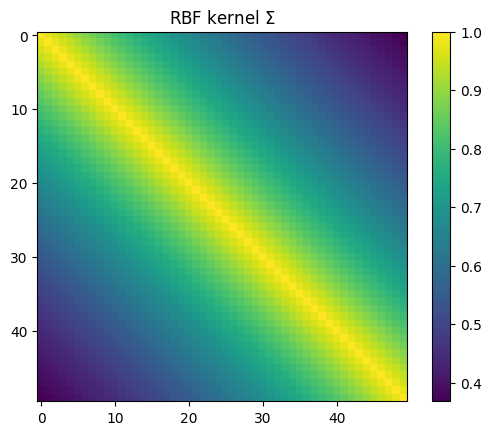

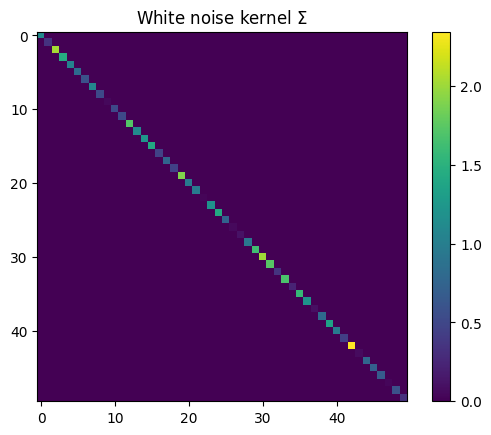

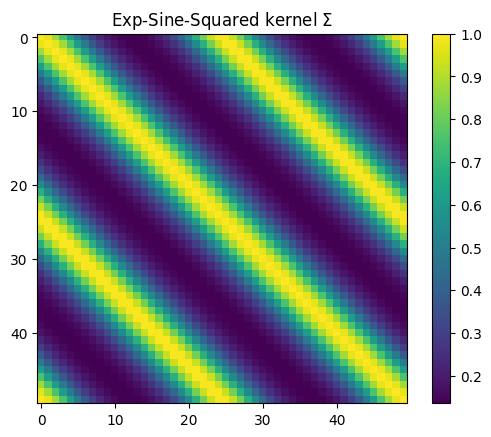

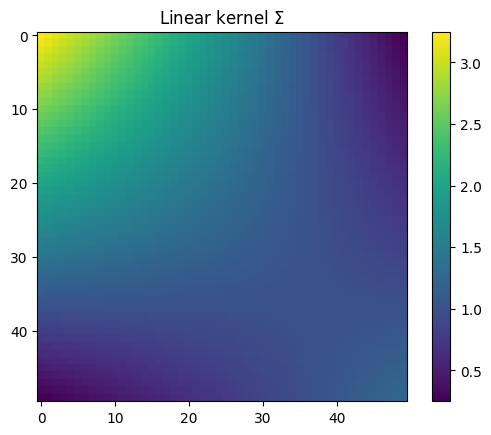

In [19]:
def get_cov_matrix(x_points, kernel, jitter=1e-8):
    """
    Creating covariance matrix by comparing each point from test data with every other point

    Returns K (Sigma) - Covariance matrix between X positions - symmetric positive definite matrix with shape (n, n)
    K is pairwise computed by partially initialized kernel function
    """
    
    Xs, X_primes = np.meshgrid(x_points, x_points)
    cov_matrix = kernel(x=np.expand_dims(Xs, -1), x_prime=np.expand_dims(X_primes, -1))
    return cov_matrix + np.eye(cov_matrix.shape[0]) * jitter

points = np.linspace(-1, 1, 5)

print("Covariance matrix of RBF kernel for prior:\n", 
    get_cov_matrix(points, rbf_kernel_partial).round(3)
)

print("\nCovariance matrix of white noise kernel for prior:\n",
    get_cov_matrix(points, white_noise_partial).round(3)
)

print("\nCovariance matrix of Exp-Sine-Squared kernel for prior:\n",
    get_cov_matrix(points, exp_sine_sq_partial).round(3)
)
print("\nCovariance matrix of linear kernel for prior:\n",
    get_cov_matrix(points, linear_kernel_partial).round(3)
)

points = np.linspace(-1, 1, 50)
plt.imshow(get_cov_matrix(points, rbf_kernel_partial).round(3), interpolation="none"); plt.title("RBF kernel $\Sigma$"); plt.colorbar(); plt.show()
plt.imshow(get_cov_matrix(points, white_noise_partial).round(3), interpolation="none"); plt.title("White noise kernel $\Sigma$"); plt.colorbar(); plt.show()
plt.imshow(get_cov_matrix(points, exp_sine_sq_partial).round(3), interpolation="none"); plt.title("Exp-Sine-Squared kernel $\Sigma$"); plt.colorbar(); plt.show()
plt.imshow(get_cov_matrix(points, linear_kernel_partial).round(3), interpolation="none"); plt.title("Linear kernel $\Sigma$"); plt.colorbar(); plt.show()

## Sampling from the prior distribution

In [20]:
def plot_gp_mu_sigmas(test_points, mu, variances, training_x=None, training_y=None):
    plt.fill_between(test_points, mu - 3*variances, mu+3*variances, color="#ebebeb", label=r"$ \mu \pm 3\sigma$")
    plt.fill_between(test_points, mu - variances, mu+variances, color="lightgrey", label=r"$ \mu \pm \sigma$")
    plt.plot(test_points, mu, color="k", label=r"$\mu$")
    if training_x is not None:
        plt.plot(training_x, training_y, "ob")
    plt.legend()

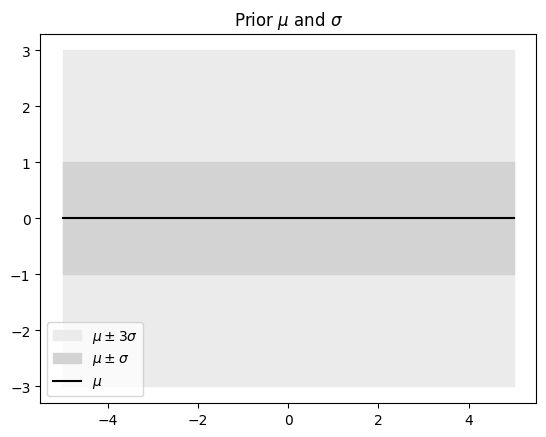

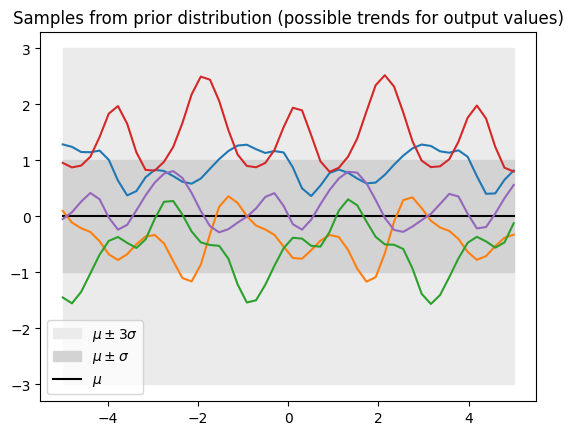

In [21]:
num_samples = 5

test_points = np.linspace(-5, 5, 50)
kernel = partial(rbf_kernel, length=5, sigma=3)
kernel2 = partial(white_noise_kernel, noise_level=0.5)
kernel3 = partial(exp_sine_squared_kernel, sigma=1, length=1.0, periodicity=4)
kernel4 = partial(linear_kernel, offset=-2.5, sigma=1.0, sigma_b=1.0)


# Use different kernel to see its effect (kernel2 or kernel3)
used_kernel = kernel3

cov_matrix = get_cov_matrix(test_points, used_kernel, jitter=1e-6)

mean = np.zeros(test_points.shape[0])
variances = cov_matrix.diagonal()

plot_gp_mu_sigmas(test_points, mean, variances)
plt.title("Prior $\mu$ and $\sigma$")
plt.show()

prior_distribution = multivariate_normal(mean, cov_matrix)

plot_gp_mu_sigmas(test_points, mean, variances)
for i in range(num_samples):
    y_samples = prior_distribution.rvs(1)
    plt.plot(test_points, y_samples, label=f"Sample {i}")
plt.title("Samples from prior distribution (possible trends for output values)")
plt.show()

# Posterior Distribution

Given training points $x$ with known $f(x)$ and test points $x_*$, the Gaussian Process would sample

$$
\begin{align}
     \begin{bmatrix}
           f(x) \\
           f(x_*)
         \end{bmatrix} \sim 
         N(0, \begin{pmatrix}
           K & K_* \\
           K_*^T & K_{**}
         \end{pmatrix})
  \end{align}
$$
Here, $K$ is the covariance matrix of training points, $K_*$ the covariance matrix of test and training points and $K_{**}$ the covariance matrix of test points.

We can also directly calculate the expected value of each point:
$$ \mu_*=K_*^T * K^{-1} * f(x)$$

$$ \sigma = K_{**} - K_{*}^T * K^{-1} * K_*$$


In [22]:
used_kernel = kernel3
n_points = 50

test_points = np.linspace(-5, 5, n_points)

observations = np.array([
    [0.5, 0.05],
    [2.3, 0.5],
    [-.5, .5],
    [-2.1, 0.5]
])


##############################
training_x = observations[:, 0]
training_y = observations[:, 1]
n_training_data = observations.shape[0]

combined_x = np.concat([training_x, test_points])
cov_matrix = get_cov_matrix(combined_x, used_kernel, jitter=1e-6)

K = cov_matrix[:n_training_data, :n_training_data]
K_star = cov_matrix[:n_training_data, n_training_data:]
K_star_transposed = cov_matrix[n_training_data:, :n_training_data]

assert (K_star.T == K_star_transposed).all()

K_star_star = cov_matrix[n_training_data:, n_training_data:]


In [23]:
def noiseless_gp(training_x, training_y, test_x, kernel_partial, *args, **kwargs):
    n_training_data = training_x.shape[0]
    combined_x = np.concat([training_x, test_x])
    cov_matrix = get_cov_matrix(combined_x, kernel_partial, *args, **kwargs)

    K = cov_matrix[:n_training_data, :n_training_data]
    K_star = cov_matrix[:n_training_data, n_training_data:]
    K_star_transposed = cov_matrix[n_training_data:, :n_training_data]
    assert (K_star.T == K_star_transposed).all()

    K_star_star = cov_matrix[n_training_data:, n_training_data:]
    posterior_mu = (K_star.T @ np.linalg.inv(K) @ training_y[:, np.newaxis]).squeeze()
    posterior_Sigma = K_star_star - K_star.T @ np.linalg.inv(K) @ K_star
    return posterior_mu, posterior_Sigma


posterior_mu, posterior_Sigma = noiseless_gp(training_x, training_y, test_points, used_kernel)

posterior_variances = posterior_Sigma.diagonal()

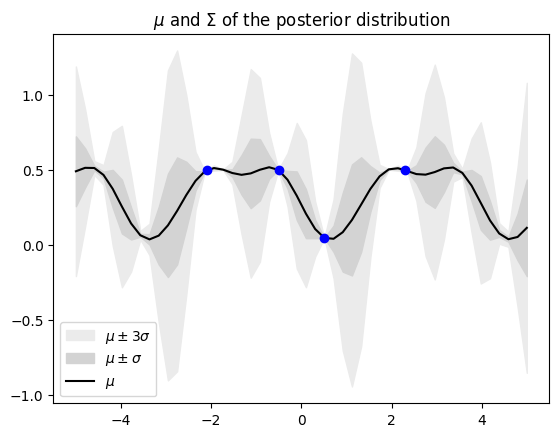

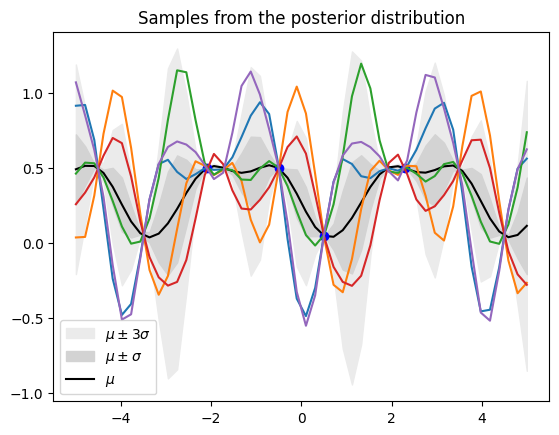

In [24]:
plot_gp_mu_sigmas(test_points, posterior_mu, posterior_variances, training_x, training_y)
plt.title("$\mu$ and $\Sigma$ of the posterior distribution")
plt.show()


plot_gp_mu_sigmas(test_points, posterior_mu, posterior_variances, training_x, training_y)
posterior_distribution = multivariate_normal(posterior_mu, posterior_Sigma)

for _ in range(5):
    test_samples = posterior_distribution.rvs(1)
    plt.plot(test_points, test_samples)
plt.title("Samples from the posterior distribution");

## Gaussian processes with noisy observations

If we consider the training observations $f(x)$ to contain some noise factor $\sigma$, we can substitute $K$ in the equations above by $K + \sigma^2 *I$. By doing that, the variance around training observations increase.

In [25]:
def gp_instable(training_x, training_y, test_x, kernel_partial, sigma, *args, **kwargs):
    """
    Gaussian process implementation with noise parameter sigma
    """
    n_training_data = training_x.shape[0]
    combined_x = np.concat([training_x, test_x])
    cov_matrix = get_cov_matrix(combined_x, kernel_partial, *args, **kwargs)

    K = cov_matrix[:n_training_data, :n_training_data]
    K_star = cov_matrix[:n_training_data, n_training_data:]
    K_star_transposed = cov_matrix[n_training_data:, :n_training_data]
    assert (K_star.T == K_star_transposed).all()

    K_star_star = cov_matrix[n_training_data:, n_training_data:]

    K_with_noise = K + sigma ** 2 * np.eye(K.shape[0])
    posterior_mu = (K_star.T @ np.linalg.inv(K_with_noise) @ training_y[:, np.newaxis]).squeeze()
    posterior_Sigma = K_star_star - K_star.T @ np.linalg.inv(K_with_noise) @ K_star
    return posterior_mu, posterior_Sigma

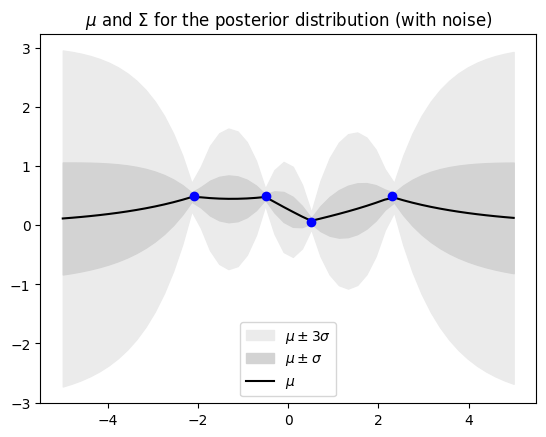

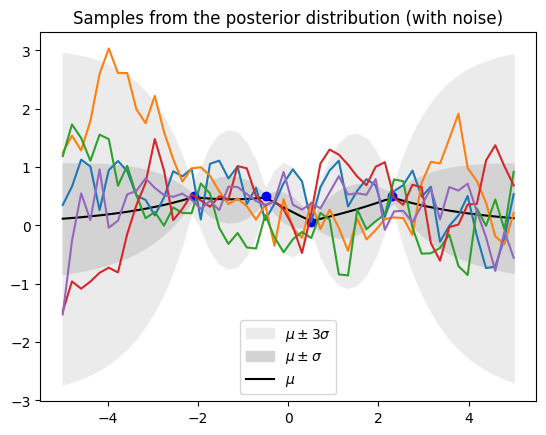

In [26]:
posterior_mu, posterior_Sigma = gp_instable(training_x, training_y, test_points, rbf_kernel_partial, sigma=0.2)

posterior_variances = posterior_Sigma.diagonal()
plot_gp_mu_sigmas(test_points, posterior_mu, posterior_variances, training_x, training_y)
plt.title("$\mu$ and $\Sigma$ for the posterior distribution (with noise)")
plt.show()

plot_gp_mu_sigmas(test_points, posterior_mu, posterior_variances, training_x, training_y)

posterior_distribution = multivariate_normal(posterior_mu, posterior_Sigma)
for _ in range(5):
    test_samples = posterior_distribution.rvs(1)
    plt.plot(test_points, test_samples)
plt.title("Samples from the posterior distribution (with noise)");

## Cholesky decomposition to avoid numeric instability with matrix inversion

Because computing the inverse matrix directly is numerically unstable, the Cholesky decomposition is used to compute $\mu$ and $\sigma$:

Cholesky decomposition can produce the "square-root" of a symmetric positive definite matrix $A$: $$A = L*L^T$$

This reduces the computation as follows:
$$\mu = K_*^T (L^T\backslash(L\backslash f(x)))\\
\sigma = K_{**} - (L\backslash K_*)^T(L\backslash K_*)$$
Here, $L\backslash f(x)$, denotes solving the linear equation system $L*y = f(x)$ for $y$ (more on [this website](https://gregorygundersen.com/blog/2019/09/12/practical-gp-regression/)).

In [27]:
from scipy.linalg import cholesky, cho_solve

def gp_stable(training_x, training_y, test_x, kernel_partial, sigma, *args, **kwargs):
    """
    Gaussian process implementation with noise parameter sigma
    """
    n_training_data = training_x.shape[0]
    combined_x = np.concat([training_x, test_x])
    cov_matrix = get_cov_matrix(combined_x, kernel_partial, *args, **kwargs)

    K = cov_matrix[:n_training_data, :n_training_data]
    K_star = cov_matrix[:n_training_data, n_training_data:]
    K_star_transposed = cov_matrix[n_training_data:, :n_training_data]
    assert (K_star.T == K_star_transposed).all()

    K_star_star = cov_matrix[n_training_data:, n_training_data:]

    K_with_noise = K + sigma ** 2 * np.eye(K.shape[0])
    
    L = cholesky(K_with_noise, lower=True)

    alpha = cho_solve((L, True), training_y)
    posterior_mu = K_star_transposed @ alpha

    v = cho_solve((L, True), K_star)
    posterior_Sigma = K_star_star - K_star_transposed @ v

    return posterior_mu, posterior_Sigma

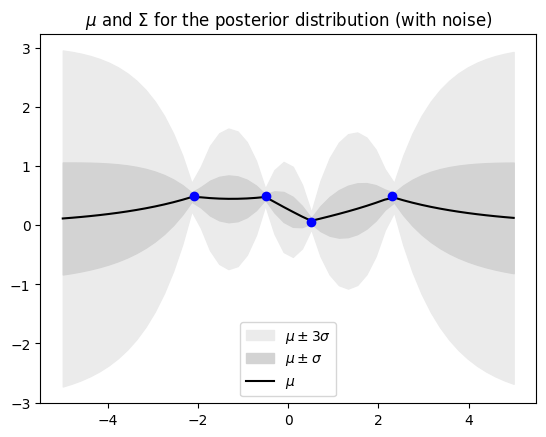

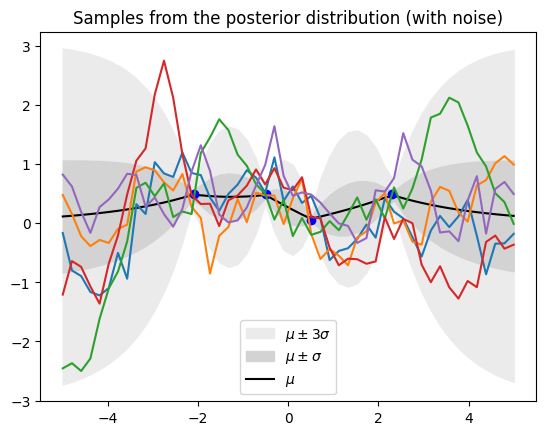

In [28]:
posterior_mu, posterior_Sigma = gp_stable(training_x, training_y, test_points, rbf_kernel_partial, sigma=0.2)

posterior_variances = posterior_Sigma.diagonal()
plot_gp_mu_sigmas(test_points, posterior_mu, posterior_variances, training_x, training_y)
plt.title("$\mu$ and $\Sigma$ for the posterior distribution (with noise)")
plt.show()

plot_gp_mu_sigmas(test_points, posterior_mu, posterior_variances, training_x, training_y)

posterior_distribution = multivariate_normal(posterior_mu, posterior_Sigma)
for _ in range(5):
    test_samples = posterior_distribution.rvs(1)
    plt.plot(test_points, test_samples)
plt.title("Samples from the posterior distribution (with noise)");